ref : https://github.com/demirayonur/Column-Generation/blob/main/ColumnGeneration_CuttingStockProblem.ipynb

## Libraries

In [2]:
from gurobipy import GRB
import gurobipy as gp
import numpy as np
np.random.seed(0)
import math

## 1. Kantorovich's Formulation

### Random Cutting Stock Problem Instance

In [3]:
class Instance(object):
    
    def __init__(self, num_order, min_order_len = 10, max_order_len = 50, 
                 min_demand = 1, max_demand = 5):
        
        self.n = num_order
        self.order_lens = np.random.randint(min_order_len, max_order_len + 1, size = self.n)
        self.demands = np.random.randint(min_demand, max_demand + 1, size = self.n)
        self.m = np.sum(self.demands)
        self.roll_len = max_order_len
        
    def summarize(self):
        print("Problem instance with ", self.n, " orders and ", self.m, "rolls")
        print("-"*50)
        print("\nOrders:\n")
        for i, order_len in enumerate(self.order_lens):
            print("\tOrder ", i, ": length= ", order_len, " demand=", self.demands[i])
        print("\nRoll Length: ", self.roll_len)

In [4]:
def optimize_kantorovich(ins_ : Instance):
    
    # model
    model = gp.Model("kantorovich_formulation")
    
    # sets (ranges)
    rolls = range(ins_.m)
    orders = range(ins_.n)
    
    # decision variables
    use_roll = model.addVars(rolls,
                            vtype = GRB.BINARY,
                            name = 'X')
    
    how_much_use = model.addVars(orders, rolls, 
                                 vtype = GRB.INTEGER,
                                 name = "Y")
    
    
    # objective function
    model.setObjective(gp.quicksum(use_roll[j] for j in rolls), GRB.MINIMIZE)
    
    
    # Const(1) : demand satisfaction constraint
    model.addConstrs(
        (gp.quicksum(how_much_use[i, j] for j in rolls)  == ins_.demands[i] for i in orders),
        'Demand'
    )
    
    # Const(2) : length constraint of roll
    model.addConstrs(
        (gp.quicksum(how_much_use[i, j] * ins_.order_lens[i] for i in orders) <= ins_.roll_len for j in rolls),
        'Length'
    )
    
    # Const(3) : x- y link
    model.addConstrs(
        how_much_use[i, j] <= use_roll[j] * ins_.demands[i] for i in orders for j in rolls
    )
    
    if False:
        model.write('kantorovich.lp') # in case you want to write the model
    
    # solve
    model.optimize()
    
    # display objective function value
    print('\nTotal Number of Rolls Used: ', model.objVal)

In [5]:
instance = Instance(50)
instance.summarize()

Problem instance with  50  orders and  157 rolls
--------------------------------------------------

Orders:

	Order  0 : length=  10  demand= 5
	Order  1 : length=  13  demand= 1
	Order  2 : length=  13  demand= 5
	Order  3 : length=  49  demand= 2
	Order  4 : length=  19  demand= 5
	Order  5 : length=  29  demand= 2
	Order  6 : length=  31  demand= 3
	Order  7 : length=  46  demand= 3
	Order  8 : length=  33  demand= 1
	Order  9 : length=  16  demand= 2
	Order  10 : length=  34  demand= 2
	Order  11 : length=  34  demand= 2
	Order  12 : length=  22  demand= 2
	Order  13 : length=  11  demand= 4
	Order  14 : length=  48  demand= 4
	Order  15 : length=  49  demand= 3
	Order  16 : length=  33  demand= 4
	Order  17 : length=  34  demand= 1
	Order  18 : length=  27  demand= 4
	Order  19 : length=  47  demand= 5
	Order  20 : length=  35  demand= 2
	Order  21 : length=  23  demand= 3
	Order  22 : length=  18  demand= 5
	Order  23 : length=  19  demand= 4
	Order  24 : length=  30  demand= 5


In [5]:
%%time
optimize_kantorovich(instance)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-08
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 8057 rows, 8007 columns and 31400 nonzeros
Model fingerprint: 0xd46fe705
Variable types: 0 continuous, 8007 integer (157 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 4553 rows and 0 columns
Presolve time: 1.16s


Presolved: 3504 rows, 8007 columns, 42704 nonzeros
Variable types: 0 continuous, 8007 integer (5652 binary)
Found heuristic solution: objective 104.0000000
Found heuristic solution: objective 102.0000000
Found heuristic solution: objective 99.0000000

Root relaxation: objective 9.300000e+01, 1722 iterations, 0.33 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   93.00000    0   65   99.00000   93.00000  6.06%     -    3s
H    0     0                      97.0000000   93.00000  4.12%     -    3s
     0     0   93.00000    0   78   97.00000   93.00000  4.12%     -    4s
H    0     0                      95.0000000   93.00000  2.11%     -    5s
     0     0   93.00000    0   80   95.00000   93.00000  2.11%     -    5s
     0     0   93.00000    0   54   95.00000   93.00000  2.11%     -    7s
     0     0   93.00000    0   72   95.00000   93.00000  

## 2. Gilmore & Gomory's Formulation

### Generate initial set of feasible pattern 

In [10]:
np.array(generate_init_patterns(instance))

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 0, 0],
       [0, 0, 3, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 5, 0],
       [0, 0, 0, ..., 0, 0, 5]])

In [11]:
def generate_init_patterns(ins_ : Instance):
    patterns = []
    for i in range(ins_.n):
        pattern_ = list(np.zeros(ins_.n).astype(int))
        pattern_[i] = int(ins_.roll_len / ins_.order_lens[i])
        patterns.append(pattern_)
    return patterns

### Master Problem

In [12]:
def define_master_problem(ins_:Instance, patterns):
    
    n_pattern = len(patterns)
    pattern_range = range(n_pattern)
    order_range = range(ins_.n)
    patterns = np.array(patterns, dtype=int)
    master_problem = gp.Model("master problem")
    
    # decision variables
    lambda_ = master_problem.addVars(pattern_range,
                                     vtype=GRB.CONTINUOUS,
                                     obj=np.ones(n_pattern),
                                     name="lambda")
    
    # direction of optimization (min or max)
    master_problem.modelSense = GRB.MINIMIZE
    
    # demand satisfaction constraint
    for i in order_range:
        master_problem.addConstr(sum(patterns[p,i]*lambda_[p] for p in pattern_range) == ins_.demands[i],
                                 "Demand[%d]" %i)
            
    # solve
    return master_problem

In [13]:
# def define_master_problem(ins_ : Instance, patterns):
#     n_pattern = len(patterns)
#     pattern_range = range(n_pattern)
#     order_range = range(ins_.n)
#     patterns = np.array(patterns, dtype = int)
#     master_problem = gp.Model("master problem")
    
#     # decision varibales
#     lambda_ = master_problem.addVars(pattern_range,
#                                      vtype = GRB.CONTINUOUS,
#                                      name = 'lambda')
    
#     # objective function
#     master_problem.setObjective(gp.quicksum(lambda_[p] for p in pattern_range), GRB.MINIMIZE)
    
#     # Const(1) : demand satisfaction constraint
#     master_problem.addConstrs(
#         (gp.quicksum(patterns[p, i] * lambda_[p] for p in pattern_range) == ins_.demands[i] for i in order_range),
#         "Demand"
#     )
    
#     return master_problem

### SubProblem (Knapsack Problem)

In [14]:
def define_subproblem(ins_ : Instance, duals):
    order_range = range(ins_.n)
    subproblem = gp.Model('subproblem')
    
    # decision variables
    x = subproblem.addVars(order_range,
                           vtype = GRB.INTEGER,
                           name = 'x')
    
    # objective function
    subproblem.setObjective(gp.quicksum(duals[i] * x[i] for i in order_range), GRB.MAXIMIZE)
    
    # Const(1) : Length constraint
    subproblem.addConstr(
        (gp.quicksum(ins_.order_lens[i] * x[i] for i in order_range) <= ins_.roll_len),
        'Length'
    )
    
    return subproblem

In [15]:

def print_solution(master, patterns):
    use = [math.ceil(i.x) for i in master.getVars()]
    for i, p in enumerate(patterns):
        if use[i]>0:
            print('Pattern ', i, ': how often we should cut: ', use[i])
            print('----------------------')
            for j,order in enumerate(p):
                if order >0:
                    print('order ', j, ' how much: ', order)
            print()

In [16]:
def column_generation(ins_ : Instance):
    
    patterns = generate_init_patterns(ins_)
    objVal_history = []
    while True:
        master_problem = define_master_problem(ins_, patterns)
        master_problem.optimize()
        objVal_history.append(master_problem.objVal)
        dual_variables = np.array([constraint.pi for constraint in master_problem.getConstrs()])
        subproblem = define_subproblem(ins_, dual_variables)
        subproblem.optimize()
        if subproblem.objVal < 1 + 1e-2:
            break
       
        patterns.append([i.x for i in subproblem.getVars()])
    print_solution(master_problem, patterns)
    print("Total number of rolls used : ", int(np.array([math.ceil(i.x) for i in master_problem.getVars()]).sum()))
        
    return objVal_history
    

In [17]:
%%time

history = column_generation(instance)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-08


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 50 rows, 50 columns and 50 nonzeros
Model fingerprint: 0x44bcee27
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 50 rows and 50 columns
Presolve time: 0.03s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1663333e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.04 seconds (0.00 work units)
Optimal objective  1.166333333e+02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count:

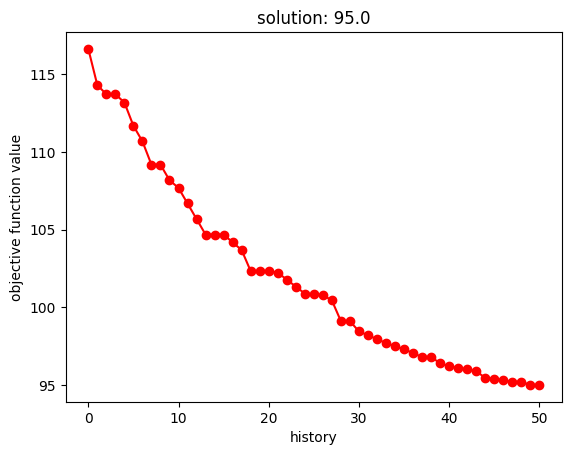

In [18]:

import matplotlib.pyplot as plt
plt.plot(list(range(len(history))), history,c='r')
plt.scatter(list(range(len(history))), history, c='r')
plt.xlabel('history')
plt.ylabel('objective function value')
title = 'solution: ' + str(history[-1])
plt.title(title)
plt.show()